In [2]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Now you can import from src
from src.data_utils import load_and_process_taxi_data

import pandas as pd

import dagshub
dagshub.init(repo_owner="tejaskolpek", repo_name="taxi_project", mlflow=True)

Initialized MLflow to track repo "tejaskolpek/taxi_project"

Repository tejaskolpek/taxi_project initialized!

In [3]:
rides1 = load_and_process_taxi_data(year=2022)
rides2=(load_and_process_taxi_data(year=2023))
rides = pd.concat([rides1,rides2],ignore_index=True)

File already exists for 2022-01.
Loading data for 2022-01...
Total records: 2,463,931
Valid records: 2,415,141
Records dropped: 48,790 (1.98%)
Successfully processed data for 2022-01.
File already exists for 2022-02.
Loading data for 2022-02...
Total records: 2,979,431
Valid records: 2,921,118
Records dropped: 58,313 (1.96%)
Successfully processed data for 2022-02.
File already exists for 2022-03.
Loading data for 2022-03...
Total records: 3,627,882
Valid records: 3,551,986
Records dropped: 75,896 (2.09%)
Successfully processed data for 2022-03.
File already exists for 2022-04.
Loading data for 2022-04...
Total records: 3,599,920
Valid records: 3,522,113
Records dropped: 77,807 (2.16%)
Successfully processed data for 2022-04.
File already exists for 2022-05.
Loading data for 2022-05...
Total records: 3,588,295
Valid records: 3,509,056
Records dropped: 79,239 (2.21%)
Successfully processed data for 2022-05.
File already exists for 2022-06.
Loading data for 2022-06...
Total records: 3,55

In [4]:
temp_rides = rides[rides["pickup_location_id"] == 43]

In [5]:
from src.data_utils import transform_raw_data_into_ts_data

ts_data = transform_raw_data_into_ts_data(temp_rides)
ts_data.head()

c:\Users\kolpe\aml500\NYC_taxi-main\NYC_taxi-main\src\data_utils.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rides["pickup_hour"] = rides["pickup_datetime"].dt.floor("h")


,pickup_hour,pickup_location_id,rides
0,2022-01-01 00:00:00,43,96
1,2022-01-01 01:00:00,43,60
2,2022-01-01 02:00:00,43,22
3,2022-01-01 03:00:00,43,8
4,2022-01-01 04:00:00,43,4


In [6]:
ts_data

,pickup_hour,pickup_location_id,rides
0,2022-01-01 00:00:00,43,96
1,2022-01-01 01:00:00,43,60
2,2022-01-01 02:00:00,43,22
3,2022-01-01 03:00:00,43,8
4,2022-01-01 04:00:00,43,4
...,...,...,...
17515,2023-12-31 19:00:00,43,55
17516,2023-12-31 20:00:00,43,72
17517,2023-12-31 21:00:00,43,50
17518,2023-12-31 22:00:00,43,28


In [7]:
ts_data = ts_data.drop(columns=["pickup_location_id"])

In [8]:
print(ts_data.head())


          pickup_hour  rides
0 2022-01-01 00:00:00     96
1 2022-01-01 01:00:00     60
2 2022-01-01 02:00:00     22
3 2022-01-01 03:00:00      8
4 2022-01-01 04:00:00      4


In [9]:
import pandas as pd

# Convert pickup_hour to datetime and set as index
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"])
ts_data.set_index("pickup_hour", inplace=True)

# Ensure data is in time series format
ts_data = ts_data.asfreq("H")  # Hourly frequency


In [10]:
import numpy as np
ts_data["rides"] = ts_data["rides"].astype(np.float32)

In [11]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(ts_data["rides"])

# Print results
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -11.985971760391038
p-value: 3.6125672806612522e-22


In [12]:
from pmdarima import auto_arima

# Find best ARMA(p, q) order
model_auto = auto_arima(ts_data["rides"], seasonal=False, stepwise=True, trace=True)

# Print best parameters
print(model_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=162977.313, Time=3.96 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=210122.120, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=165205.279, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=191455.692, Time=1.64 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=164599.482, Time=2.82 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=164969.807, Time=3.44 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=12.83 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=162484.750, Time=4.62 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=163384.864, Time=3.26 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=162468.514, Time=5.53 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=159185.213, Time=13.63 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=162619.471, Time=4.96 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=162608.488, Time=12.34 sec
 ARIMA(4,0,4)(0,0,0)[0]             : AIC=156766.742, Time=15.75 sec
 ARIMA(3

In [13]:
from sklearn.metrics import mean_absolute_error

# Split data into train and test sets
train_size = int(len(ts_data) * 0.8)  # Use 80% for training, 20% for testing
train, test = ts_data.iloc[:train_size], ts_data.iloc[train_size:]

# Fit ARMA model on training data
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train["rides"], order=(4, 0, 3))  # Best ARMA(p=4, q=4)
arma_result = model.fit()

# Forecast on the test set
forecast = arma_result.forecast(steps=len(test))

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(test["rides"], forecast)
print("Mean Absolute Error (MAE):", mae)


c:\Users\kolpe\anaconda3\envs\nyc_taxi_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\kolpe\anaconda3\envs\nyc_taxi_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error (MAE): 23.33091267671975


In [14]:
import mlflow
mlflow.set_experiment("model_arma")

# Start an MLflow run
with mlflow.start_run():
        mlflow.log_metric("mean_absolute_error", mae)

2025/03/06 21:17:06 INFO mlflow.tracking.fluent: Experiment with name 'model_arma' does not exist. Creating a new experiment.


🏃 View run dapper-snake-182 at: https://dagshub.com/tejaskolpek/taxi_project.mlflow/#/experiments/7/runs/eb012c3451324653a8e9ed29ba7e845d
🧪 View experiment at: https://dagshub.com/tejaskolpek/taxi_project.mlflow/#/experiments/7


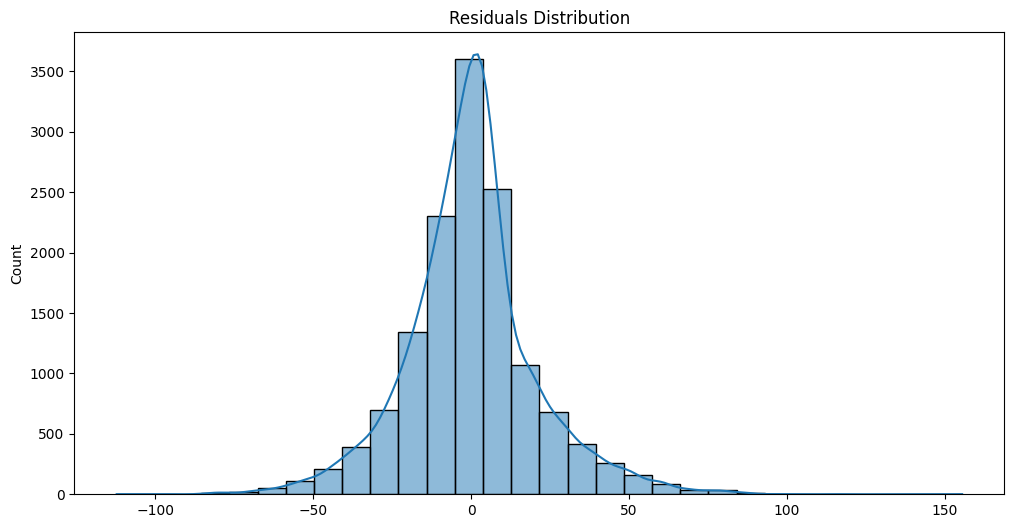

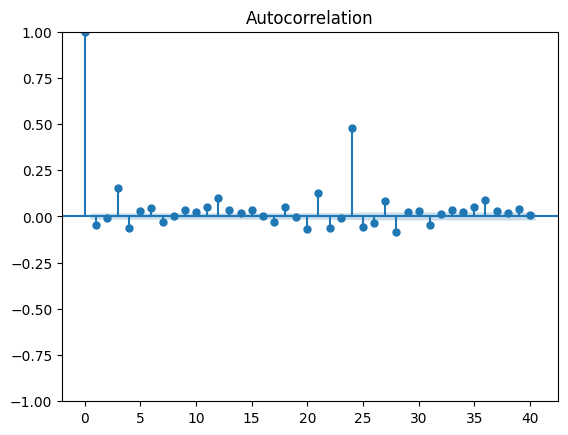

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Plot residuals
residuals = arma_result.resid

plt.figure(figsize=(12,6))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residuals Distribution")
plt.show()

# Check ACF (Autocorrelation) of residuals
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()


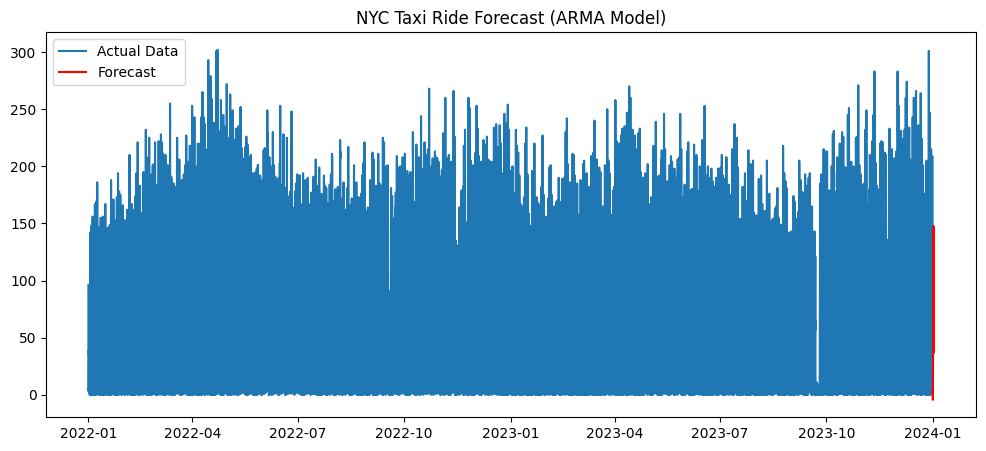

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Forecast next 24 hours
forecast_steps = 24
forecast = arma_result.forecast(steps=forecast_steps)

# Create date index for forecast
forecast_index = pd.date_range(start=ts_data.index[-1], periods=forecast_steps+1, freq="H")[1:]

# Plot results
plt.figure(figsize=(12,5))
plt.plot(ts_data.index, ts_data["rides"], label="Actual Data")
plt.plot(forecast_index, forecast, label="Forecast", color="red")
plt.legend()
plt.title("NYC Taxi Ride Forecast (ARMA Model)")
plt.show()
